In [2]:
import openslide
from openslide import open_slide
from openslide.deepzoom import DeepZoomGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import valis
import cv2

import seaborn as sns

/well/rittscher/users/qdv200/conda/skylake/envs/valis_env/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/well/rittscher/users/qdv200/conda/skylake/envs/valis_env/lib/python3.10/site-packages/valis/affine_optimizer.py:311: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @nba.jit()
/well/rittscher/users/qdv200/conda/skylake/envs/valis_env/lib/python3.10/site-packages/valis/affi

In [2]:
x_sc=100
y_sc=100
ts = 256

350.0
84.0


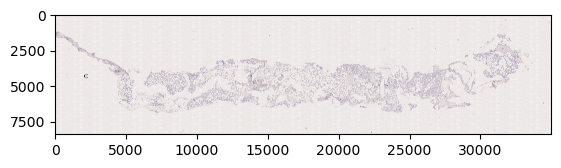

In [3]:
#get image mask


#make tiles
image = "b-ET-CALR-2021-02-19-11-12-00.ndpi"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/"

slide_path = os.path.join(filepath, image)

slide = open_slide(slide_path)

print(slide.level_dimensions[0][0]/ts)
print(slide.level_dimensions[0][1]/ts)

img = slide.get_thumbnail(((slide.level_dimensions[0][0]/ts)*x_sc, (slide.level_dimensions[0][1]/ts)*y_sc))
img = np.array(img)

plt.imshow(img)

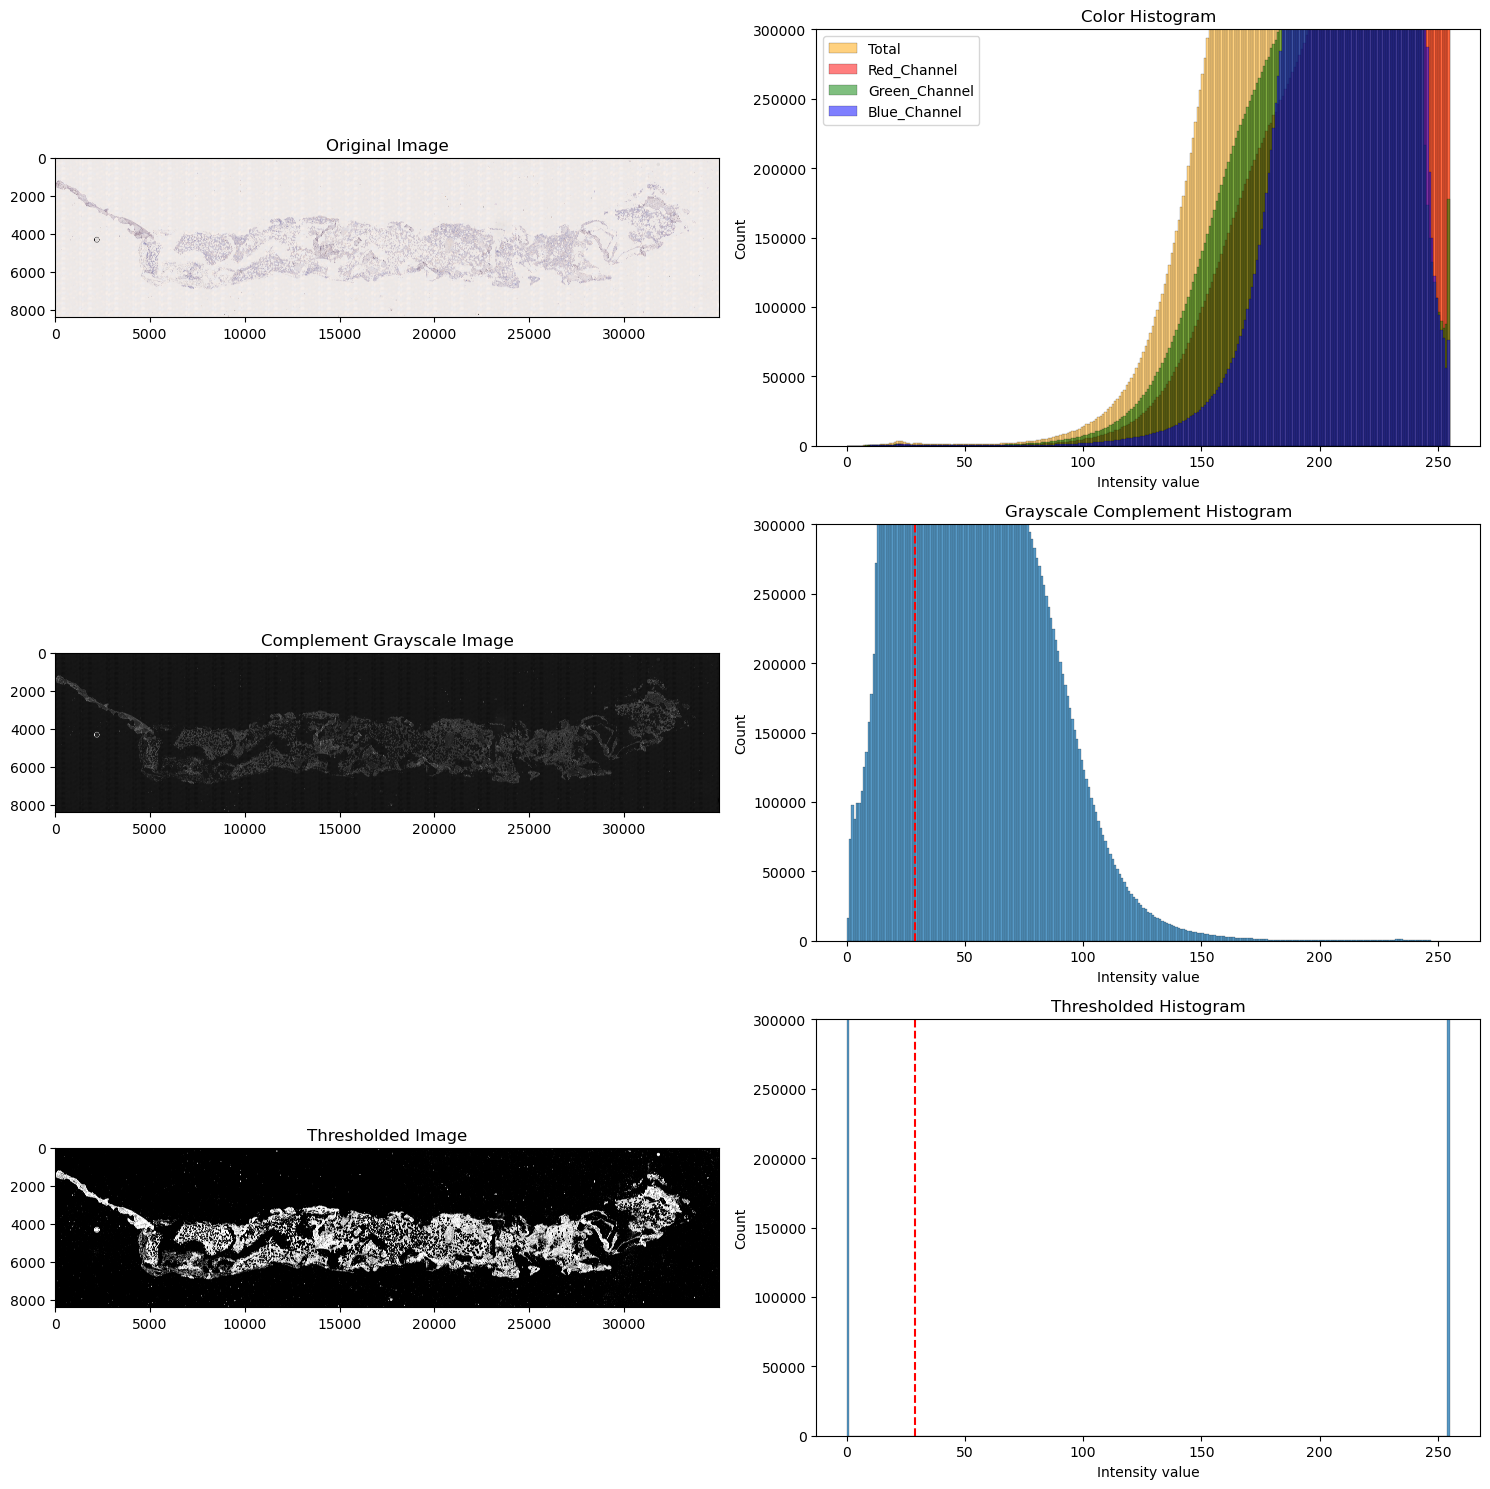

In [4]:
#https://www.kaggle.com/code/nghihuynh/wsi-preprocessing-tiling-tissue-segmentation
#apply otsu to get tissue mask

def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

def histogram(img, thres_img, img_c, thres):
    """
    style: ['color', 'grayscale']
    """ 
    plt.figure(figsize=(15,15))
    
    plt.subplot(3,2,1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(3,2,2)
    sns.histplot(img.ravel(), bins=np.arange(0,256), color='orange', alpha=0.5)
    sns.histplot(img[:,:,0].ravel(), bins=np.arange(0,256), color='red', alpha=0.5)
    sns.histplot(img[:,:,1].ravel(), bins=np.arange(0,256), color='Green', alpha=0.5)
    sns.histplot(img[:,:,2].ravel(), bins=np.arange(0,256), color='Blue', alpha=0.5)
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Color Histogram')
    
    plt.subplot(3,2,3)
    plt.imshow(img_c, cmap='gist_gray')
    plt.title('Complement Grayscale Image')
    
    plt.subplot(3,2,4)
    sns.histplot(img_c.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Grayscale Complement Histogram')
    
    plt.subplot(3,2,5)
    plt.imshow(thres_img, cmap='gist_gray')
    plt.title('Thresholded Image')
    
    plt.subplot(3,2,6)
    sns.histplot(thres_img.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Thresholded Histogram')
    
    plt.tight_layout()
    plt.show()

thres, thres_img, img_c = thresholding(img, method='triangle')
histogram(img, thres_img, img_c, thres)

In [11]:
#get the tiles which are tissue

#split thres im into tiles

# sx, sy = slide.dimensions
# ix, iy = thres_img.shape

# ratiox = sx/512
# ratioy = sy/512

M = x_sc
N = y_sc

print(M, N)

#https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python

tile_dict = {}
non_tile_dict = {}
for x in range(0,thres_img.shape[0],M):
    for y in range(0,thres_img.shape[1],N):
        tile = thres_img[x:x+M,y:y+N]
        if tile.mean() > thres:
            tile_dict[(y/y_sc, x/x_sc)] = tile
        else:
            non_tile_dict[(y/y_sc, x/x_sc)] = tile

print(thres_img.shape[0]/M)
print(thres_img.shape[1]/N)
print(slide.dimensions[0]/ts)
print(slide.dimensions[1]/ts)

100 100
84.0
350.0
350.0
84.0


In [12]:
print(len(non_tile_dict))
print(len(tile_dict))

23001
6399


302.0 31.0


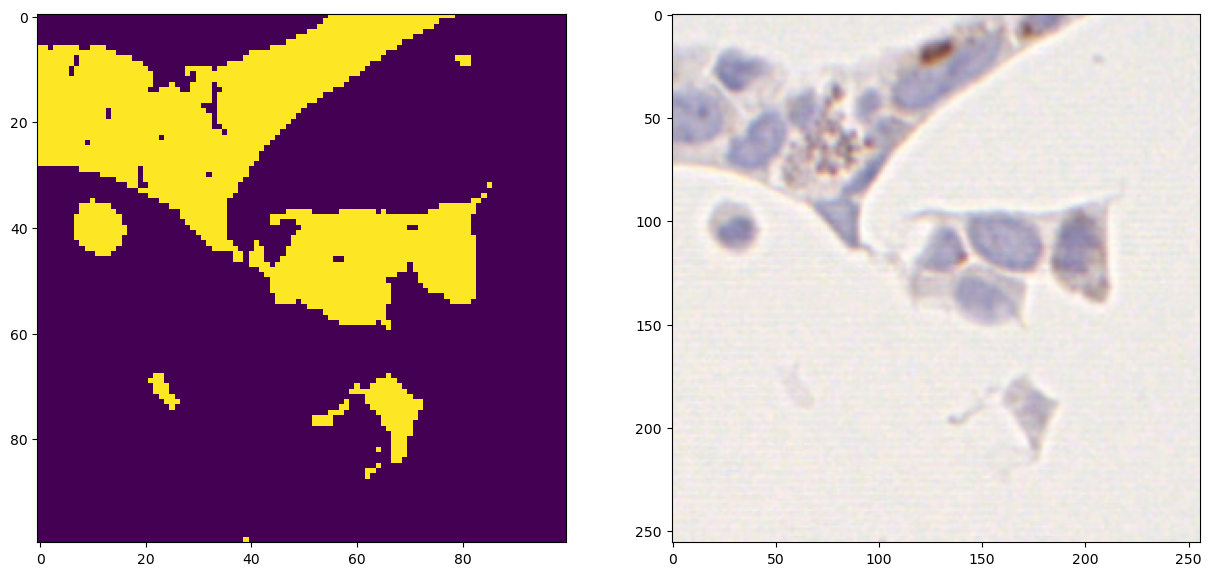

In [13]:
#plot tiles as subplots

fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs = axs.ravel()

key_list = list(tile_dict.keys())

#print(len(key_list))

#get random integer between 0 and length of key list
rand_num = np.random.randint(0, len(key_list))

tup = key_list[rand_num]

print(tup[0], tup[1])

axs[0].imshow(tile_dict[tup])
img = slide.read_region((int(ts*tup[0]), int(ts*tup[1])), 0, (ts,ts))
axs[1].imshow(img)

plt.show()

28.0 10.0


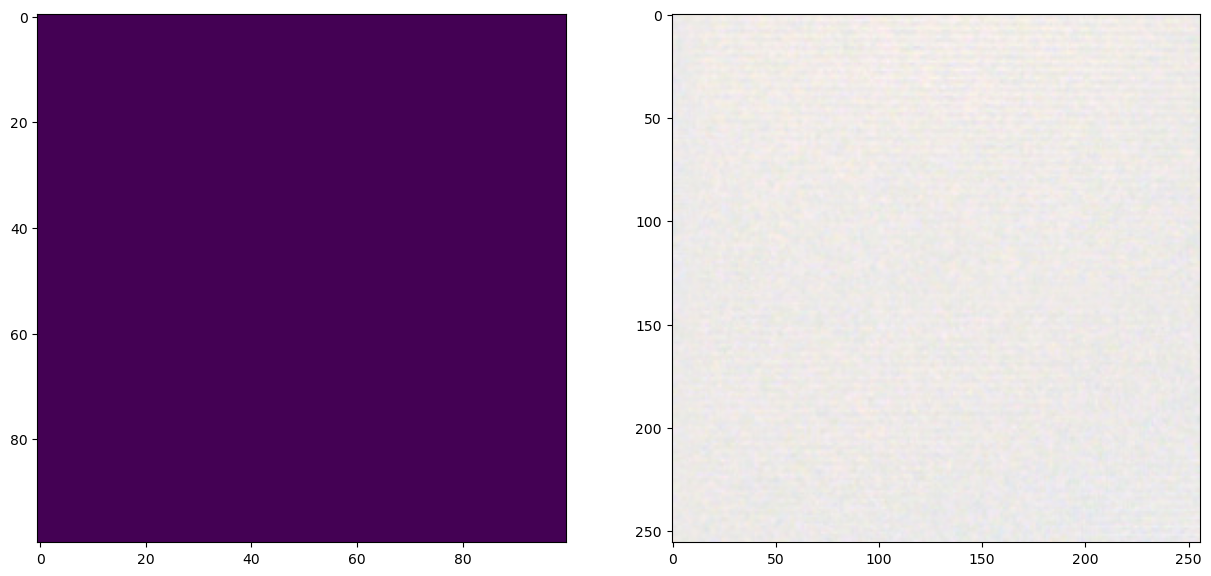

In [16]:
#plot tiles as subplots

fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs = axs.ravel()

key_list = list(non_tile_dict.keys())

#print(len(key_list))

#get random integer between 0 and length of key list
rand_num = np.random.randint(0, len(key_list))

tup = key_list[rand_num]

print(tup[0], tup[1])

axs[0].imshow(non_tile_dict[tup])
img = slide.read_region((int(ts*tup[0]), int(ts*tup[1])), 0, (ts,ts))
axs[1].imshow(img)

plt.show()

In [26]:
import random

print(len(tile_dict))
print(len(non_tile_dict))

per = int(len(tile_dict)*0.1)
per

#randomly select per number of the tiles from non_tile_dict

non_tile_dict_keys = list(non_tile_dict.keys())
#non_tile_dict_keys

# #select 639 random keys from non_tile_dict_keys
rand_keys = random.sample(non_tile_dict_keys, per)
rand_keys



6399
23001


[(96.0, 78.0),
 (7.0, 81.0),
 (29.0, 52.0),
 (10.0, 64.0),
 (202.0, 17.0),
 (216.0, 21.0),
 (174.0, 31.0),
 (268.0, 21.0),
 (65.0, 11.0),
 (37.0, 7.0),
 (130.0, 13.0),
 (241.0, 30.0),
 (40.0, 54.0),
 (84.0, 20.0),
 (225.0, 71.0),
 (298.0, 72.0),
 (127.0, 29.0),
 (323.0, 71.0),
 (307.0, 58.0),
 (120.0, 3.0),
 (348.0, 6.0),
 (313.0, 71.0),
 (250.0, 35.0),
 (5.0, 34.0),
 (225.0, 9.0),
 (341.0, 43.0),
 (290.0, 67.0),
 (25.0, 75.0),
 (128.0, 72.0),
 (191.0, 63.0),
 (331.0, 76.0),
 (210.0, 5.0),
 (19.0, 16.0),
 (259.0, 14.0),
 (197.0, 10.0),
 (319.0, 76.0),
 (347.0, 34.0),
 (279.0, 14.0),
 (62.0, 25.0),
 (330.0, 34.0),
 (47.0, 16.0),
 (270.0, 11.0),
 (73.0, 28.0),
 (231.0, 28.0),
 (188.0, 71.0),
 (80.0, 0.0),
 (166.0, 69.0),
 (35.0, 53.0),
 (28.0, 66.0),
 (249.0, 64.0),
 (129.0, 62.0),
 (223.0, 13.0),
 (15.0, 1.0),
 (93.0, 18.0),
 (248.0, 21.0),
 (99.0, 12.0),
 (93.0, 32.0),
 (262.0, 18.0),
 (6.0, 61.0),
 (75.0, 28.0),
 (134.0, 21.0),
 (323.0, 63.0),
 (333.0, 24.0),
 (168.0, 50.0),
 (130.0, 

In [6]:
#save tile_dict as json

import json

with open('/well/rittscher/users/qdv200/MPN/GAN_tiles/13062023_bET_256_tile_dict.json', 'w') as fp:
    json.dump(tile_dict, fp)



TypeError: keys must be str, int, float, bool or None, not tuple

In [29]:
#make tiles
image = "b-ET-CALR-2021-02-19-11-12-00.ndpi"

base = "/well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/"
slide = open_slide(os.path.join(filepath, image))

try:
    to_unicode = unicode
except NameError:
    to_unicode = str

#MAKE IHC IMAGES

tiles = DeepZoomGenerator(slide, tile_size=ts, overlap=0, limit_bounds=False)
n = tiles.level_count
cols, rows = tiles.level_tiles[n-1]
for row in range(rows):
        for col in range(cols):

            if (col, row) in tile_dict.keys():

                image_name = os.path.splitext(image)[0]
                tile_dir = base
                if not os.path.exists(tile_dir):
                    os.makedirs(tile_dir) 
                
                tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
                if not os.path.exists(os.path.join(tile_name + ".png")):
                    print("Now saving tile with title: ", tile_name)
                    temp_tile = tiles.get_tile(n-1, (col, row))
                    temp_tile_RGB = temp_tile.convert('RGB')
                    temp_tile_np = np.array(temp_tile_RGB)
                    plt.imsave(tile_name + ".png", temp_tile_np)
                else:
                    continue
            
            elif (col, row) in rand_keys: 
                    
                image_name = os.path.splitext(image)[0]
                tile_dir = base
                if not os.path.exists(tile_dir):
                    os.makedirs(tile_dir) 
                
                tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
                if not os.path.exists(os.path.join(tile_name + ".png")):
                    print("Now saving tile with title: ", tile_name)
                    temp_tile = tiles.get_tile(n-1, (col, row))
                    temp_tile_RGB = temp_tile.convert('RGB')
                    temp_tile_np = np.array(temp_tile_RGB)
                    plt.imsave(tile_name + ".png", temp_tile_np)
                else:
                    continue   

            else:
                continue

Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_11_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_34_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_74_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_80_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_93_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_111_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_155_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_175_0
Now saving ti

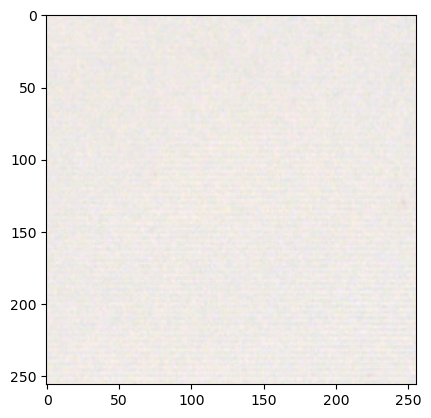

In [3]:
#load in one of the 256 tiles to check 

import matplotlib.pyplot as plt

tile = plt.imread("/well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256/b-ET-CALR-2021-02-19-11-12-00_327_83.png")
plt.imshow(tile)



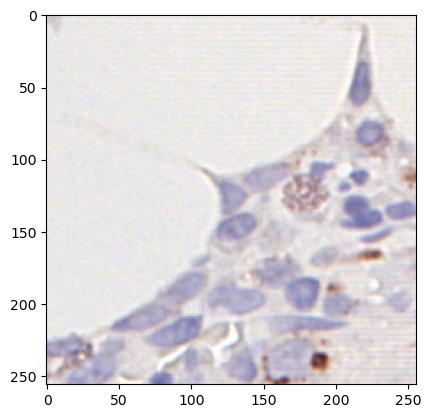

In [4]:
#make tiles just the blue chanel

#get a list of files in the directory

import os

num = 10

base = "/well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256"

files = os.listdir(base)
im = plt.imread(os.path.join(base, files[num]))
plt.imshow(im)

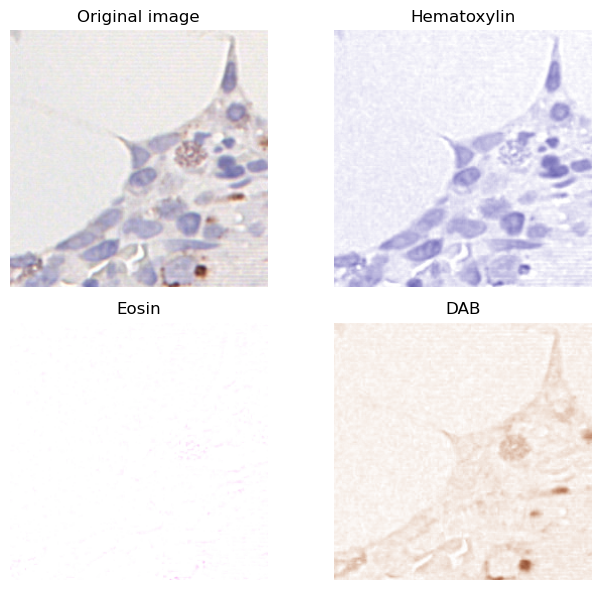

In [6]:
# #let's just do scikit on this one image and see what comes out

# from skimage import data
# from skimage.color import rgb2hed, hed2rgb


# im = np.array(im)
# im = im[:, :, :3]

# # Separate the stains from the IHC image
# ihc_hed = rgb2hed(im)

# # Create an RGB image for each of the stains
# null = np.zeros_like(ihc_hed[:, :, 0])
# ihc_h = hed2rgb(np.stack((ihc_hed[:, :, 0], null, null), axis=-1))
# ihc_e = hed2rgb(np.stack((null, ihc_hed[:, :, 1], null), axis=-1))
# ihc_d = hed2rgb(np.stack((null, null, ihc_hed[:, :, 2]), axis=-1))

# # Display
# fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(im)
# ax[0].set_title("Original image")

# ax[1].imshow(ihc_h)
# ax[1].set_title("Hematoxylin")

# ax[2].imshow(ihc_e)
# ax[2].set_title("Eosin")  # Note that there is no Eosin stain in this image

# ax[3].imshow(ihc_d)
# ax[3].set_title("DAB")

# for a in ax.ravel():
#     a.axis('off')

# fig.tight_layout()

In [7]:
#don't bother registering 

#make tiles from he now 

x_sc=100
y_sc=100
ts = 256

308.0
105.0


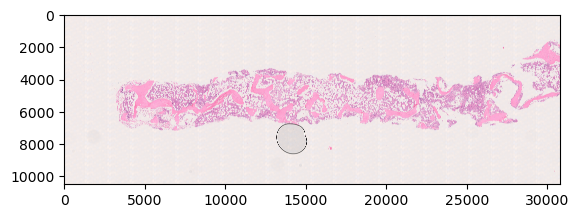

In [13]:
#get image mask


#make tiles
image = "b-ET-2021-02-08-12-25-45-CALR.ndpi"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/valis_slides/"

slide_path = os.path.join(filepath, image)

slide = open_slide(slide_path)

print(slide.level_dimensions[0][0]/ts)
print(slide.level_dimensions[0][1]/ts)

img = slide.get_thumbnail(((slide.level_dimensions[0][0]/ts)*x_sc, (slide.level_dimensions[0][1]/ts)*y_sc))
img = np.array(img)

plt.imshow(img)

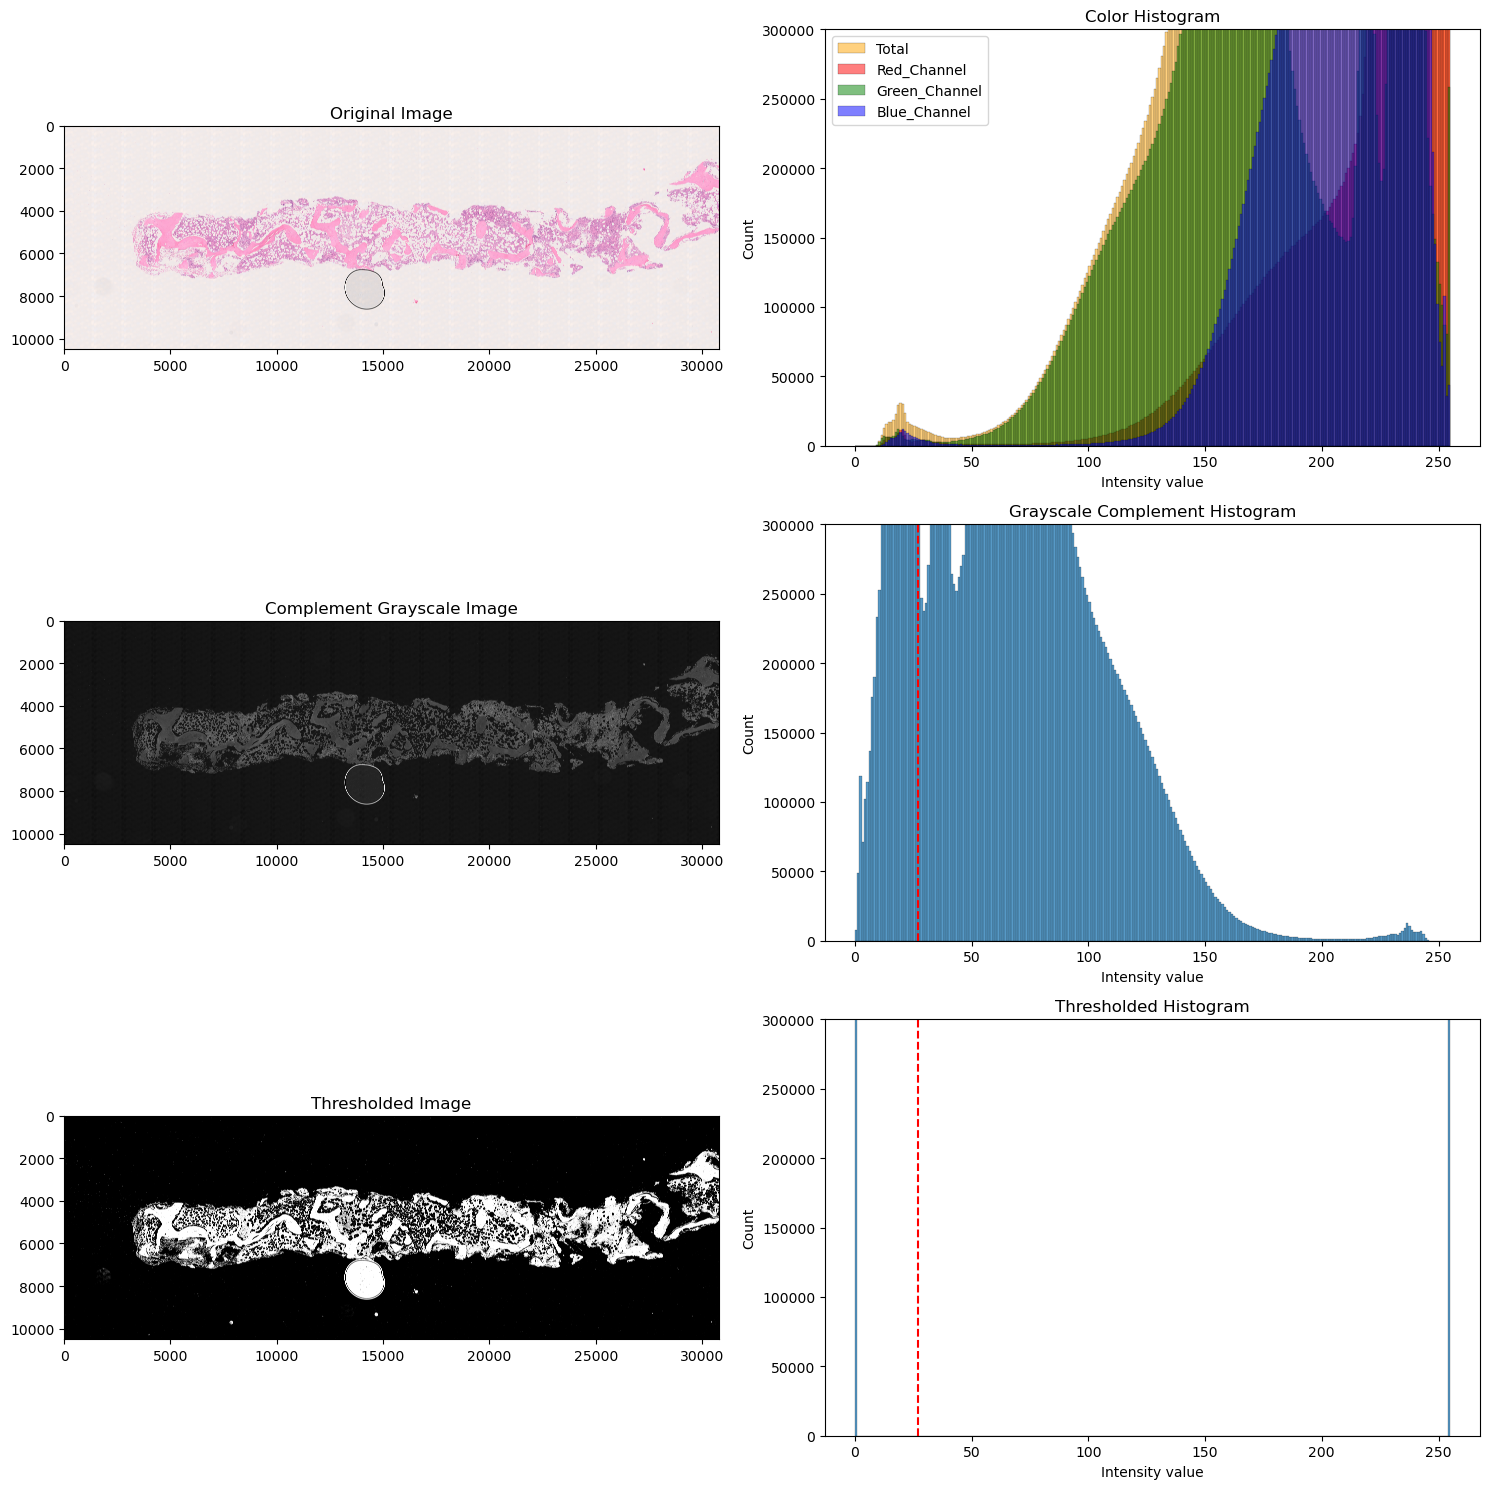

In [9]:
#https://www.kaggle.com/code/nghihuynh/wsi-preprocessing-tiling-tissue-segmentation
#apply otsu to get tissue mask

def thresholding(img, method='otsu'):
    # convert to grayscale complement image
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    thres, thres_img = 0, img_c.copy()
    if method == 'otsu':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    elif method == 'triangle':
        thres, thres_img = cv2.threshold(img_c, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)
    return thres, thres_img, img_c

def histogram(img, thres_img, img_c, thres):
    """
    style: ['color', 'grayscale']
    """ 
    plt.figure(figsize=(15,15))
    
    plt.subplot(3,2,1)
    plt.imshow(img)
    plt.title('Original Image')
    
    plt.subplot(3,2,2)
    sns.histplot(img.ravel(), bins=np.arange(0,256), color='orange', alpha=0.5)
    sns.histplot(img[:,:,0].ravel(), bins=np.arange(0,256), color='red', alpha=0.5)
    sns.histplot(img[:,:,1].ravel(), bins=np.arange(0,256), color='Green', alpha=0.5)
    sns.histplot(img[:,:,2].ravel(), bins=np.arange(0,256), color='Blue', alpha=0.5)
    plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Color Histogram')
    
    plt.subplot(3,2,3)
    plt.imshow(img_c, cmap='gist_gray')
    plt.title('Complement Grayscale Image')
    
    plt.subplot(3,2,4)
    sns.histplot(img_c.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Grayscale Complement Histogram')
    
    plt.subplot(3,2,5)
    plt.imshow(thres_img, cmap='gist_gray')
    plt.title('Thresholded Image')
    
    plt.subplot(3,2,6)
    sns.histplot(thres_img.ravel(), bins=np.arange(0,256))
    plt.axvline(thres, c='red', linestyle="--")
    plt.ylim(0,0.3e6)
    plt.xlabel('Intensity value')
    plt.title('Thresholded Histogram')
    
    plt.tight_layout()
    plt.show()

thres, thres_img, img_c = thresholding(img, method='triangle')
histogram(img, thres_img, img_c, thres)

In [10]:
#get the tiles which are tissue

#split thres im into tiles

# sx, sy = slide.dimensions
# ix, iy = thres_img.shape

# ratiox = sx/512
# ratioy = sy/512

M = x_sc
N = y_sc

print(M, N)

#https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python

tile_dict = {}
non_tile_dict = {}
for x in range(0,thres_img.shape[0],M):
    for y in range(0,thres_img.shape[1],N):
        tile = thres_img[x:x+M,y:y+N]
        if tile.mean() > thres:
            tile_dict[(y/y_sc, x/x_sc)] = tile
        else:
            non_tile_dict[(y/y_sc, x/x_sc)] = tile

print(thres_img.shape[0]/M)
print(thres_img.shape[1]/N)
print(slide.dimensions[0]/ts)
print(slide.dimensions[1]/ts)

100 100
105.0
308.0
308.0
105.0


In [11]:
print(len(non_tile_dict))
print(len(tile_dict))

24970
7370


176.0 49.0


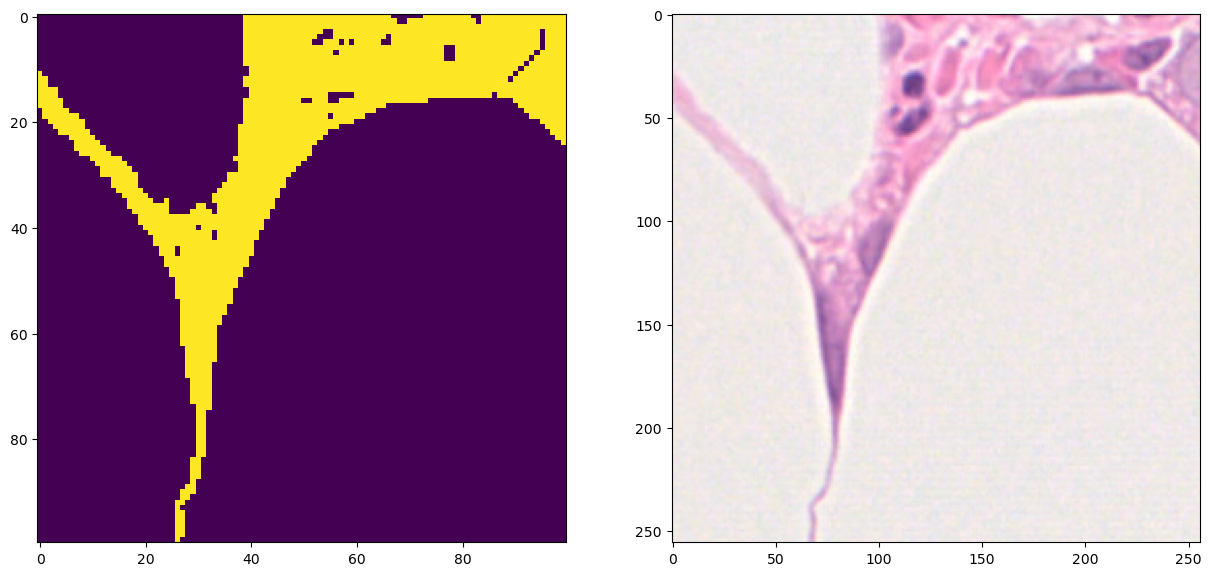

In [14]:
#plot tiles as subplots

fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs = axs.ravel()

key_list = list(tile_dict.keys())

#print(len(key_list))

#get random integer between 0 and length of key list
rand_num = np.random.randint(0, len(key_list))

tup = key_list[rand_num]

print(tup[0], tup[1])

axs[0].imshow(tile_dict[tup])
img = slide.read_region((int(ts*tup[0]), int(ts*tup[1])), 0, (ts,ts))
axs[1].imshow(img)

plt.show()

291.0 56.0


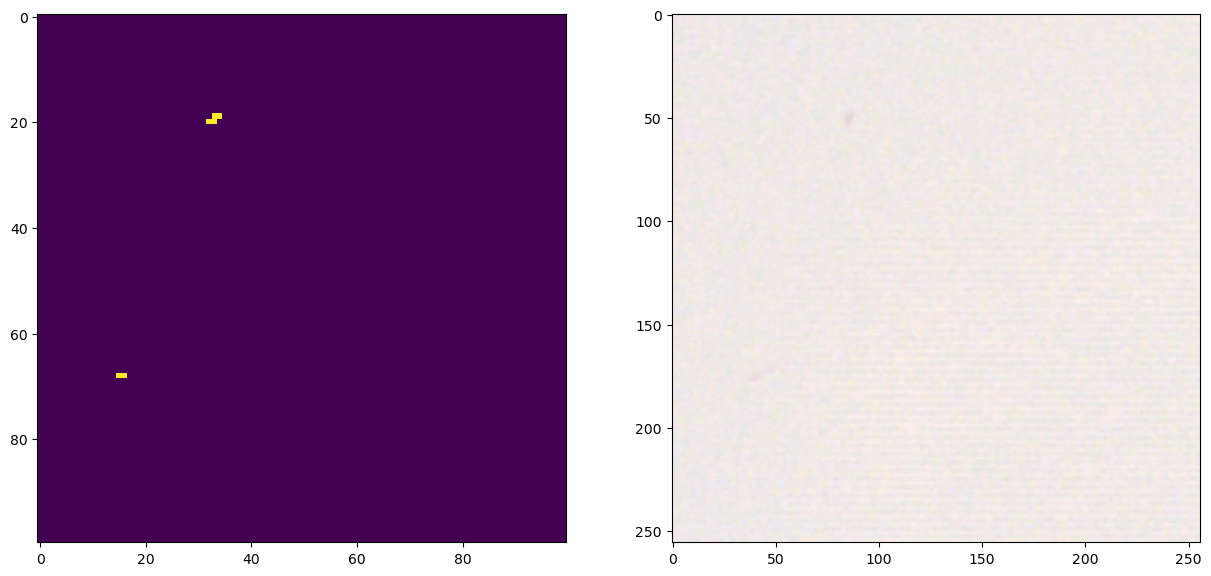

In [15]:
#plot tiles as subplots

fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs = axs.ravel()

key_list = list(non_tile_dict.keys())

#print(len(key_list))

#get random integer between 0 and length of key list
rand_num = np.random.randint(0, len(key_list))

tup = key_list[rand_num]

print(tup[0], tup[1])

axs[0].imshow(non_tile_dict[tup])
img = slide.read_region((int(ts*tup[0]), int(ts*tup[1])), 0, (ts,ts))
axs[1].imshow(img)

plt.show()

In [16]:
import random

print(len(tile_dict))
print(len(non_tile_dict))

per = int(len(tile_dict)*0.1)
per

#randomly select per number of the tiles from non_tile_dict

non_tile_dict_keys = list(non_tile_dict.keys())
#non_tile_dict_keys

# #select 639 random keys from non_tile_dict_keys
rand_keys = random.sample(non_tile_dict_keys, per)
rand_keys



7370
24970


[(113.0, 11.0),
 (211.0, 37.0),
 (200.0, 16.0),
 (265.0, 89.0),
 (57.0, 4.0),
 (43.0, 92.0),
 (278.0, 46.0),
 (275.0, 12.0),
 (306.0, 58.0),
 (262.0, 14.0),
 (70.0, 2.0),
 (161.0, 85.0),
 (60.0, 85.0),
 (25.0, 64.0),
 (241.0, 33.0),
 (220.0, 36.0),
 (282.0, 2.0),
 (59.0, 100.0),
 (173.0, 98.0),
 (249.0, 74.0),
 (68.0, 91.0),
 (171.0, 96.0),
 (217.0, 98.0),
 (153.0, 100.0),
 (50.0, 74.0),
 (228.0, 102.0),
 (8.0, 95.0),
 (215.0, 38.0),
 (252.0, 94.0),
 (307.0, 69.0),
 (19.0, 49.0),
 (227.0, 74.0),
 (202.0, 12.0),
 (203.0, 95.0),
 (43.0, 101.0),
 (40.0, 13.0),
 (22.0, 103.0),
 (112.0, 25.0),
 (142.0, 50.0),
 (157.0, 86.0),
 (297.0, 85.0),
 (158.0, 33.0),
 (79.0, 81.0),
 (301.0, 65.0),
 (23.0, 70.0),
 (197.0, 26.0),
 (276.0, 98.0),
 (111.0, 94.0),
 (175.0, 33.0),
 (203.0, 28.0),
 (173.0, 0.0),
 (306.0, 63.0),
 (285.0, 6.0),
 (43.0, 33.0),
 (151.0, 83.0),
 (147.0, 19.0),
 (42.0, 33.0),
 (109.0, 2.0),
 (249.0, 6.0),
 (54.0, 34.0),
 (94.0, 0.0),
 (77.0, 39.0),
 (21.0, 98.0),
 (212.0, 11.0),
 

In [17]:
#make tiles
image = "b-ET-2021-02-08-12-25-45-CALR.ndpi"

base = "/well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he"
filepath = "/well/rittscher/users/qdv200/MPN/HE-IHC-BMT/valis_slides/"
slide = open_slide(os.path.join(filepath, image))

try:
    to_unicode = unicode
except NameError:
    to_unicode = str

#MAKE IHC IMAGES

tiles = DeepZoomGenerator(slide, tile_size=ts, overlap=0, limit_bounds=False)
n = tiles.level_count
cols, rows = tiles.level_tiles[n-1]
for row in range(rows):
        for col in range(cols):

            if (col, row) in tile_dict.keys():

                image_name = os.path.splitext(image)[0]
                tile_dir = base
                if not os.path.exists(tile_dir):
                    os.makedirs(tile_dir) 
                
                tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
                if not os.path.exists(os.path.join(tile_name + ".png")):
                    print("Now saving tile with title: ", tile_name)
                    temp_tile = tiles.get_tile(n-1, (col, row))
                    temp_tile_RGB = temp_tile.convert('RGB')
                    temp_tile_np = np.array(temp_tile_RGB)
                    plt.imsave(tile_name + ".png", temp_tile_np)
                else:
                    continue
            
            elif (col, row) in rand_keys: 
                    
                image_name = os.path.splitext(image)[0]
                tile_dir = base
                if not os.path.exists(tile_dir):
                    os.makedirs(tile_dir) 
                
                tile_name = os.path.join(tile_dir, image_name + '_%d_%d' % (col, row))
                if not os.path.exists(os.path.join(tile_name + ".png")):
                    print("Now saving tile with title: ", tile_name)
                    temp_tile = tiles.get_tile(n-1, (col, row))
                    temp_tile_RGB = temp_tile.convert('RGB')
                    temp_tile_np = np.array(temp_tile_RGB)
                    plt.imsave(tile_name + ".png", temp_tile_np)
                else:
                    continue   

            else:
                continue

Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-ET-2021-02-08-12-25-45-CALR_48_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-ET-2021-02-08-12-25-45-CALR_77_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-ET-2021-02-08-12-25-45-CALR_94_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-ET-2021-02-08-12-25-45-CALR_100_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-ET-2021-02-08-12-25-45-CALR_109_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-ET-2021-02-08-12-25-45-CALR_138_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-ET-2021-02-08-12-25-45-CALR_173_0
Now saving tile with title:  /well/rittscher/users/qdv200/MPN/GAN_tiles/ihc2he/test_256_he/b-ET-2021-02-08-12-25-4

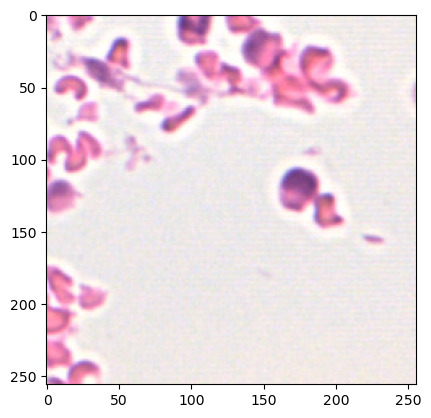

In [20]:
#show he images

files = os.listdir(base)
im = plt.imread(os.path.join(base, files[10]))
plt.imshow(im)